In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm


###Load & inspect data


In [5]:
df = pd.read_csv("StudentPerformanceFactors.csv")
df.head()


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [7]:
df.describe()


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [8]:
df.isna().sum()


Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

### Define target and predictors

In [9]:
y = df["Exam_Score"]
X = df.drop(columns=["Exam_Score"])


### Identify numerical & categorical columns

***Numerical variables***

In [10]:
num_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity"
]


***Categorical variables***

In [11]:
cat_cols = [
    "Parental_Involvement",
    "Access_to_Resources",
    "Extracurricular_Activities",
    "Motivation_Level",
    "Internet_Access",
    "Family_Income",
    "Teacher_Quality",
    "School_Type",
    "Peer_Influence",
    "Learning_Disabilities",
    "Parental_Education_Level",
    "Distance_from_Home",  
    "Gender"
]


### Preprocessing (missing values + encoding)

In [12]:
# Numerical preprocessing
numeric_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
# Categorical preprocessing
categorical_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_preprocess, num_cols),
    ("cat", categorical_preprocess, cat_cols)
])



### Constant varaibles

In [13]:
RANDOM_STATE = 42
ALPHAS = np.logspace(-3, 1, 50)
N_BOOTSTRAP = 1000


### Train / test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


### Linear regression (Frequentist inference)

In [16]:
X_ols = X_train.copy()

# drop rows where target is missing and keep alignment
mask = ~y_train.isna()
X_ols = X_ols.loc[mask].reset_index(drop=True)
y_train_aligned = y_train.loc[mask].reset_index(drop=True)

# fill numeric and categorical missing values
for col in num_cols:
    X_ols[col] = X_ols[col].fillna(X_ols[col].median())
for col in cat_cols:
    X_ols[col] = X_ols[col].fillna(X_ols[col].mode()[0])

# encode and add constant
X_ols = pd.get_dummies(X_ols, drop_first=True)
X_ols = sm.add_constant(X_ols)

# ensure numeric dtypes and then fit with aligned y
X_ols = X_ols.astype(float)
ols_model = sm.OLS(y_train_aligned.astype(float), X_ols).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     494.1
Date:                Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:59:01   Log-Likelihood:                -11383.
No. Observations:                5285   AIC:                         2.282e+04
Df Residuals:                    5257   BIC:                         2.301e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [17]:
lin_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("linreg", LinearRegression())
])

lin_pipe.fit(X_train, y_train)

y_pred = lin_pipe.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lin = r2_score(y_test, y_pred)

rmse_lin, r2_lin


(np.float64(1.804444509272284), 0.7696495724907312)

### Ridge Regression

In [18]:
ridge_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("ridge", Ridge())
])


In [19]:
ridge_scores = []

for a in ALPHAS:
    ridge_pipe.set_params(ridge__alpha=a)
    score = -cross_val_score(
        ridge_pipe, X_train, y_train,
        scoring="neg_mean_squared_error", cv=5
    ).mean()
    ridge_scores.append(score)

best_alpha_ridge = ALPHAS[np.argmin(ridge_scores)]
best_alpha_ridge


np.float64(5.689866029018293)

In [20]:
ridge_pipe.set_params(ridge__alpha=best_alpha_ridge)
ridge_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Hours_Studied',
                                                   'Attendance', 'Sleep_Hours',
                                                   'Previous_Scores',
                                                   'Tutoring_Sessions',
                                                   'Physical_Activity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   O...rst',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Parental_Involvement',
                                                   'Access_to_Resources',
                                                   'Extracurricular_Activities',
                                                   'Motivation_Level',
                                                   'Internet_Access',
                                                   'Family_Income',
                                                   'Teacher_Quality',
                                                   'School_Type',
                                                   'Peer_Influence',
                                                   'Learning_Disabilities',
                                                   'Parental_Education_Level',
                                                   'Distance_from_Home',
                                                   'Gender'])])),
                ('ridge', Ridge(alpha=np.float64(5.689866029018293)))])

### Lasso Regression

In [21]:
lasso_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("lasso", Lasso(max_iter=5000))
])


In [22]:
lasso_scores = []

for a in ALPHAS:
    lasso_pipe.set_params(lasso__alpha=a)
    score = -cross_val_score(
        lasso_pipe, X_train, y_train,
        scoring="neg_mean_squared_error", cv=5
    ).mean()
    lasso_scores.append(score)

best_alpha_lasso = ALPHAS[np.argmin(lasso_scores)]
best_alpha_lasso


np.float64(0.0014563484775012444)

In [24]:
lasso_pipe.set_params(lasso__alpha=best_alpha_lasso)
lasso_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Hours_Studied',
                                                   'Attendance', 'Sleep_Hours',
                                                   'Previous_Scores',
                                                   'Tutoring_Sessions',
                                                   'Physical_Activity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   O...
                                                                                 handle_unknown='ignore'))]),
                                                  ['Parental_Involvement',
                                                   'Access_to_Resources',
                                                   'Extracurricular_Activities',
                                                   'Motivation_Level',
                                                   'Internet_Access',
                                                   'Family_Income',
                                                   'Teacher_Quality',
                                                   'School_Type',
                                                   'Peer_Influence',
                                                   'Learning_Disabilities',
                                                   'Parental_Education_Level',
                                                   'Distance_from_Home',
                                                   'Gender'])])),
                ('lasso',
                 Lasso(alpha=np.float64(0.0014563484775012444),
                       max_iter=5000))])

In [25]:
feature_names = (
    num_cols +
    list(
        lasso_pipe.named_steps["preprocess"]
        .named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(cat_cols)
    )
)

coef = lasso_pipe.named_steps["lasso"].coef_

coef_table = pd.DataFrame({
    "Variable": feature_names,
    "Coefficient": coef
})

coef_table = coef_table[coef_table["Coefficient"] != 0]
coef_table = coef_table.sort_values(
    by="Coefficient", key=abs, ascending=False
)

coef_table


,Variable,Coefficient
1,Attendance,2.289101
8,Access_to_Resources_Low,-2.082398
6,Parental_Involvement_Low,-1.984162
0,Hours_Studied,1.755059
14,Family_Income_Low,-1.089834
7,Parental_Involvement_Medium,-1.056291
20,Peer_Influence_Positive,1.034342
11,Motivation_Level_Low,-1.023028
9,Access_to_Resources_Medium,-1.017811
16,Teacher_Quality_Low,-0.990332


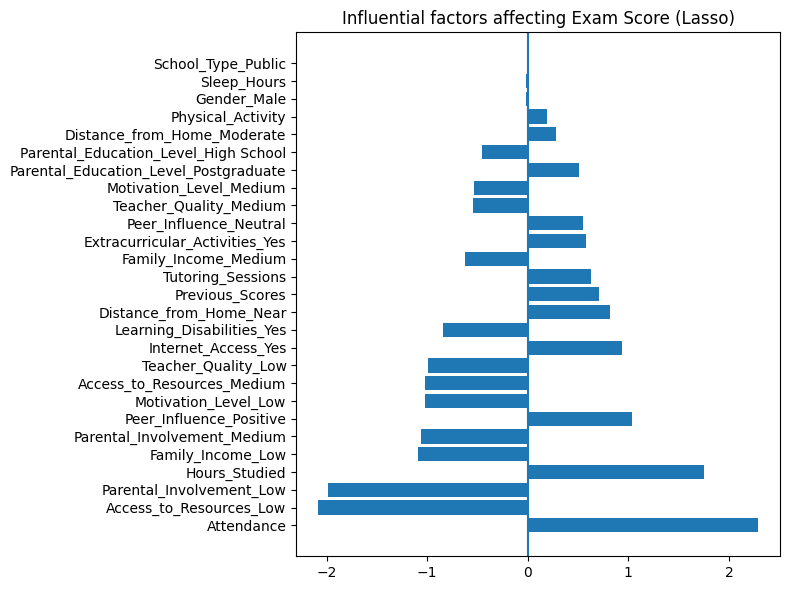

In [26]:
plt.figure(figsize=(8, 6))
plt.barh(coef_table["Variable"], coef_table["Coefficient"])
plt.axvline(0)
plt.title("Influential factors affecting Exam Score (Lasso)")
plt.tight_layout()
plt.show()


### Bootsttrap Stability

In [28]:
boot_coefs = np.zeros((N_BOOTSTRAP, len(coef)))

for i in range(N_BOOTSTRAP):
    idx = np.random.choice(len(X_train), len(X_train), replace=True)
    X_b = X_train.iloc[idx]
    y_b = y_train.iloc[idx]

    lasso_pipe.fit(X_b, y_b)
    boot_coefs[i] = lasso_pipe.named_steps["lasso"].coef_


### Bootstrap confiedence interval

In [29]:
lower = np.percentile(boot_coefs, 2.5, axis=0)
upper = np.percentile(boot_coefs, 97.5, axis=0)

ci_table = pd.DataFrame({
    "Variable": feature_names,
    "Lower CI": lower,
    "Upper CI": upper
})

ci_table = ci_table[ci_table["Lower CI"] * ci_table["Upper CI"] > 0]
ci_table


,Variable,Lower CI,Upper CI
0,Hours_Studied,1.683111,1.826329
1,Attendance,2.230607,2.345338
3,Previous_Scores,0.642372,0.766403
4,Tutoring_Sessions,0.568168,0.682695
5,Physical_Activity,0.134957,0.262124
6,Parental_Involvement_Low,-2.159794,-1.801734
7,Parental_Involvement_Medium,-1.196504,-0.923737
8,Access_to_Resources_Low,-2.244901,-1.928884
9,Access_to_Resources_Medium,-1.153519,-0.875559
10,Extracurricular_Activities_Yes,0.464176,0.680958


### Model Comparison

In [30]:
models = {
    "Linear": lin_pipe,
    "Ridge": ridge_pipe,
    "Lasso": lasso_pipe
}

for name, model in models.items():
    y_hat = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    r2 = r2_score(y_test, y_hat)
    print(f"{name}: RMSE={rmse:.2f}, R²={r2:.3f}")


Linear: RMSE=1.80, R²=0.770
Ridge: RMSE=1.80, R²=0.770
Lasso: RMSE=1.81, R²=0.768
